# Copy data from gdrive and prepare folder structure

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
# Prepare folder structure
PROJECT_FOLDER = "/gdrive/MyDrive/Projects/solafune-solar_panel"
DATA_FOLDER = "/home/data/"
TRAIN_DATA_FOLDER = DATA_FOLDER + 'train/'
TEST_DATA_FOLDER = DATA_FOLDER + 'test/'
SAMPLE_DATA_FOLDER = DATA_FOLDER + 'sample/'

In [3]:
# Copy data from gdrive to colab
!rm -rf /home/data
!mkdir {DATA_FOLDER}
!mkdir {TRAIN_DATA_FOLDER}
!mkdir {TEST_DATA_FOLDER}
!mkdir {SAMPLE_DATA_FOLDER}
!unzip -qq {PROJECT_FOLDER}/train.zip -d {TRAIN_DATA_FOLDER}
!unzip -qq {PROJECT_FOLDER}/evaluation.zip -d {TEST_DATA_FOLDER}
!unzip -qq {PROJECT_FOLDER}/sample.zip -d {SAMPLE_DATA_FOLDER}

In [4]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=7358cb791adf52d1ffd7d05d908b6a3939ca60a0bba3bb87209ad34e2b60fe7a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a316a9841d583885759ebbe6f3cf864c3768b8277ffc648d6f590ff069ef747e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# Imports

In [5]:
!pip install segmentation-models-pytorch

In [6]:
import os
import random
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [7]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import segmentation_models_pytorch as smp

# Load data

In [8]:
def load_image_masks(folder_name, file_names):
    image_data = []
    mask_data = []

    for fn in tqdm(file_names):
        postfix = fn.split("_")[3]
        image_data.append(tifffile.imread(f"{folder_name}/s2_image/{fn}"))
        mask_data.append(tifffile.imread(f"{folder_name}/mask/train_mask_{postfix}"))

    return image_data, mask_data

In [9]:
train_image_files = os.listdir(f'{TRAIN_DATA_FOLDER}s2_image/')
train_image_data, train_mask_data = load_image_masks(TRAIN_DATA_FOLDER, train_image_files)

100%|██████████| 2066/2066 [00:04<00:00, 445.72it/s]


# Dataset

Images are not the same length so I use padding to increase the size and the center crop to have all images of size 32x32. This way all images are the same size but the spatial resolution is not changed like it would be when using resize.

In [10]:
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.Pad((6,6), padding_mode="reflect"),
    v2.RandomRotation(degrees=90),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.CenterCrop((32,32)),
    v2.ToDtype(torch.float32, scale=False),
])


val_transforms = v2.Compose([
    v2.ToImage(),
    v2.Pad((6,6), padding_mode="reflect"),
    v2.CenterCrop((32,32)),
    v2.ToDtype(torch.float32, scale=False),
])

torch.Size([12, 32, 32]) torch.Size([1, 32, 32])


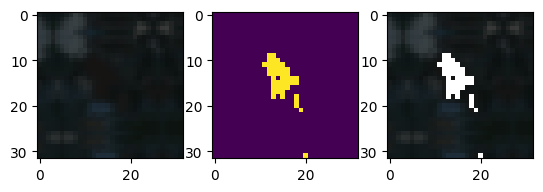

In [37]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        images,
        masks,
        transforms,
    ):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, index):
        image = self.images[index]# / 10_000 # scale by scaling factor
        mask = self.masks[index]
        mask = np.expand_dims(mask, 2) # [x,y] => [x,y,1]
        image, mask = self.transforms(image, mask)

        return {"image": image, "mask": mask}

ds = ImageTrainDataset(train_image_data, train_mask_data, transforms=train_transforms)
d = ds.__getitem__(2)
print(d["image"].shape, d["mask"].shape)

_, axes = plt.subplots(1,3)
axes[0].imshow(d["image"][1:4].permute(1,2,0) / 10_000)
axes[1].imshow(d["mask"][0])
axes[2].imshow((d["mask"][0] + d["image"][1:4] / 10_000).permute(1,2,0))

# Metric

In [12]:
# https://github.com/earthpulse/pytorchEO/blob/main/pytorch_eo/metrics/segmentation.py
# image wise f1 score with zero division = 1
def f1_score(predictions, targets, th=0.5, eps=1e-7):
    predictions = predictions > th

    tp = torch.sum(targets * predictions, axis=(-2, -1))
    fp = torch.sum(predictions, axis=(-2, -1)) - tp
    fn = torch.sum(targets, axis=(-2, -1)) - tp
    f1 = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    return torch.mean(f1)

In [13]:
def find_best_threshold(predictions, targets):
    score_5 = f1_score(predictions, targets)
    best_score = 0
    best_th = -1
    for i in range(100):
        _score = f1_score(predictions, targets, th = i/100)
        if _score > best_score:
            best_score = _score
            best_th = i / 100

    return score_5, best_score, best_th

# Prediction plotting and summary

In [14]:
from sklearn.metrics import f1_score as sklearn_f1

In [15]:
def calc_group_score(true_mask, predictions, threshold):
    """
    Groups samples by positive mask coverage and calculates mean f1 score for each group.
    """

    f1_scores = []
    for i in range(len(true_mask)):
        _s = sklearn_f1(true_mask[i].ravel(), predictions[i].ravel() > threshold, zero_division=1)
        f1_scores.append(_s)

    # calculate true mask coverage
    pv_coverage = np.array([np.mean(_mask) for _mask in true_mask])
    # convert coverage to 10 coverage classes
    pv_coverage_class = (pv_coverage * 5).astype(int) + 1
    # set class 0 to samples with empty mask
    pv_coverage_class[pv_coverage == 0] = 0

    results = pd.DataFrame()
    results["f1_scores"] = f1_scores
    results["pv_coverage"] = pv_coverage
    results["pv_coverage_class"] = pv_coverage_class

    mean_results = results.groupby(by=["pv_coverage_class"])["f1_scores"].mean().reset_index()
    display(mean_results.T)

In [16]:
def plot_predictions(true_mask, predictions, threshold, N=10):
    fig, axes = plt.subplots(3,N, figsize=(20,4))
    for i in range(N):
        _f1_score = sklearn_f1(predictions[i].ravel() > threshold, true_mask[i].ravel(), zero_division=1)
        axes[0][i].imshow(predictions[i, 0, :])
        axes[1][i].imshow(predictions[i, 0, :] > threshold)
        axes[2][i].imshow(true_mask[i, 0, :])
        axes[0][i].title.set_text(f"f1: {_f1_score:.4f}")

    axes[0][0].set_ylabel("Probability")
    axes[1][0].set_ylabel("Prediction")
    axes[2][0].set_ylabel("True mask")
    plt.show()

# Train and evaluate functions

In [17]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [18]:
def evaluate_model(cfg, model, data_loader, epoch=-1):
    loss_fn = DiceBCELoss()

    model.eval()
    val_loss = 0

    targets = []
    predictions = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    for step, data in tk0:
        input = data["image"].to(cfg.device, non_blocking=True)
        target = data["mask"].to(cfg.device, non_blocking=True)

        with torch.no_grad():
            logits = model(input)

        loss = loss_fn(logits, target)
        val_loss += loss.item()

        targets.append(target.detach().cpu())
        predictions.append(logits.detach().cpu())
        del input, target, logits

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    predictions = F.sigmoid(predictions)

    val_loss /= total_len
    base_score, best_score, best_th = find_best_threshold(predictions, targets)

    print(f'Epoch {epoch} validation loss = {val_loss:.4f}, base f1 score (0.5 threshold) = {base_score:.4f} (best threhold: {best_th} -> f1 {best_score:.4f})')

    # Every 5 epochs calculate score for each group and plot some predictions
    if (epoch +1) % 5 == 0:
        mean_results = calc_group_score(targets.numpy(), predictions.numpy(), best_th)
        plot_predictions(targets.numpy(), predictions.numpy(), best_th)

    return val_loss, best_score

In [19]:
def train_epoch(cfg, model, train_loader, optimizer, scheduler, epoch):
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.apex)
    loss_fn = DiceBCELoss()

    model.train()
    train_loss = 0
    learning_rate_history = []

    targets = []
    predictions = []

    total_len = len(train_loader)
    tk0 = tqdm(enumerate(train_loader), total=total_len)
    for step, data in tk0:
        input = data["image"].to(cfg.device, non_blocking=True)
        target = data["mask"].to(cfg.device, non_blocking=True)

        # https://pytorch.org/blog/accelerating-training-on-nvidia-gpus-with-pytorch-automatic-mixed-precision/
        with torch.cuda.amp.autocast(enabled=cfg.apex):
            logits = model(input)
            loss = loss_fn(logits, target)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.clip_val)

        train_loss += loss.item()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        if scheduler is None:
            lr = optimizer.param_groups[0]['lr']
        else:
            scheduler.step()
            lr = scheduler.get_last_lr()[0]

        tk0.set_description(f"Epoch {epoch} training {step+1}/{total_len} [LR {lr:0.6f}] - loss: {train_loss/(step+1):.4f}")
        learning_rate_history.append(lr)

        targets.append(target.detach().cpu())
        predictions.append(logits.detach().cpu())
        del input, target

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    predictions = F.sigmoid(predictions)

    train_loss /= total_len
    base_score, best_score, best_th = find_best_threshold(predictions, targets)

    print(f'\nEpoch {epoch} train loss = {train_loss:.4f}, base f1 score (0.5 threshold) = {base_score:.4f} (best threhold: {best_th} -> f1 {best_score:.4f})')
    return train_loss, best_score, learning_rate_history

# Loss function

In [20]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')

        inputs = F.sigmoid(inputs)
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(total + smooth)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE

# Train model

In [21]:
class CFG:
    seed=42
    N_folds = 5
    train_folds = [0] # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=False # switch to true to use half precision

    epochs = 50

    clip_val = 1000.
    batch_size = 64
    gradient_accumulation_steps = 1

    lr = 1e-3
    weight_decay=0.0

## Split data

Images have various coverage of solar panels so we will split the data trying to keep the ratio of different coverages in train and validation similar.

- calculate the coverage in each mask
- convert coverage into integer representing group
- set zero mask to a special group

Final groups:
- 0 - samples wihout any solar panels
- 1 - samples with solar panels covering from 0 to 20% of the image
- 2 - samples with solar panels covering from 20% to 40% of the image
- ...
- 6 - samples with solar panels covering from 80% to 100% of the image

In [22]:
from sklearn.model_selection import StratifiedKFold

<Axes: xlabel='pv_coverage_class', ylabel='Count'>

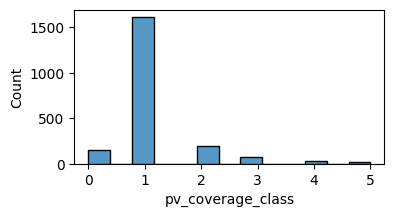

In [23]:
pv_coverage = np.array([np.mean(_mask) for _mask in train_mask_data])
pv_coverage_class = (pv_coverage * 5).astype(int) + 1 # convert coverage into integer
pv_coverage_class[pv_coverage == 0] = 0 # set samples without solar panels into special group

train_data = pd.DataFrame()
train_data["image_file_name"] = train_image_files
train_data["pv_coverage"] = pv_coverage
train_data["pv_coverage_class"] = pv_coverage_class
train_data["fold"] = -1

plt.figure(figsize=(4,2))
sns.histplot(train_data["pv_coverage_class"])

In [24]:
sgkf = StratifiedKFold(n_splits=CFG.N_folds, random_state=CFG.seed, shuffle=True)
for i, (train_index, test_index) in enumerate(sgkf.split(train_data["image_file_name"].values, train_data["pv_coverage_class"].values)):
    train_data.loc[test_index, "fold"] = i

## Train folds

,0,1,2,3,4,5
pv_coverage_class,0,1,2,3,4,5
valid,30,323,38,15,5,3
train,116,1292,153,60,21,10


100%|██████████| 414/414 [00:00<00:00, 660.95it/s]
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 35.6MB/s]


Model parameters: 21_703_697


Epoch 0 training 25/25 [LR 0.000362] - loss: 1.4261: 100%|██████████| 25/25 [00:07<00:00,  3.49it/s]



Epoch 0 train loss = 1.4261, base f1 score (0.5 threshold) = 0.0926 (best threhold: 0.0 -> f1 0.1263)


100%|██████████| 7/7 [00:00<00:00, 11.48it/s]


Epoch 0 validation loss = 1.3583, base f1 score (0.5 threshold) = 0.1349 (best threhold: 0.43 -> f1 0.1398)
New best score: 0.0000 -> 0.1398


Epoch 1 training 25/25 [LR 0.000917] - loss: 1.1141: 100%|██████████| 25/25 [00:03<00:00,  7.50it/s]



Epoch 1 train loss = 1.1141, base f1 score (0.5 threshold) = 0.2394 (best threhold: 0.47 -> f1 0.2402)


100%|██████████| 7/7 [00:00<00:00, 20.94it/s]


Epoch 1 validation loss = 1.9810, base f1 score (0.5 threshold) = 0.1369 (best threhold: 0.94 -> f1 0.2226)
New best score: 0.1398 -> 0.2226


Epoch 2 training 25/25 [LR 0.001000] - loss: 0.7634: 100%|██████████| 25/25 [00:03<00:00,  7.45it/s]



Epoch 2 train loss = 0.7634, base f1 score (0.5 threshold) = 0.3285 (best threhold: 0.36 -> f1 0.3433)


100%|██████████| 7/7 [00:00<00:00, 22.12it/s]


Epoch 2 validation loss = 0.7007, base f1 score (0.5 threshold) = 0.3381 (best threhold: 0.36 -> f1 0.3610)
New best score: 0.2226 -> 0.3610


Epoch 3 training 25/25 [LR 0.000997] - loss: 0.6044: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]



Epoch 3 train loss = 0.6044, base f1 score (0.5 threshold) = 0.3648 (best threhold: 0.23 -> f1 0.3975)


100%|██████████| 7/7 [00:00<00:00, 21.78it/s]


Epoch 3 validation loss = 0.5895, base f1 score (0.5 threshold) = 0.4107 (best threhold: 0.33 -> f1 0.4238)
New best score: 0.3610 -> 0.4238


Epoch 4 training 25/25 [LR 0.000993] - loss: 0.5291: 100%|██████████| 25/25 [00:03<00:00,  7.27it/s]



Epoch 4 train loss = 0.5291, base f1 score (0.5 threshold) = 0.3988 (best threhold: 0.22 -> f1 0.4326)


100%|██████████| 7/7 [00:00<00:00, 13.11it/s]


Epoch 4 validation loss = 0.5446, base f1 score (0.5 threshold) = 0.3638 (best threhold: 0.14 -> f1 0.4181)


,0,1,2,3,4
pv_coverage_class,0.000000,1.00000,2.000000,3.000000,4.000000
f1_scores,0.333333,0.36863,0.780014,0.762876,0.902956


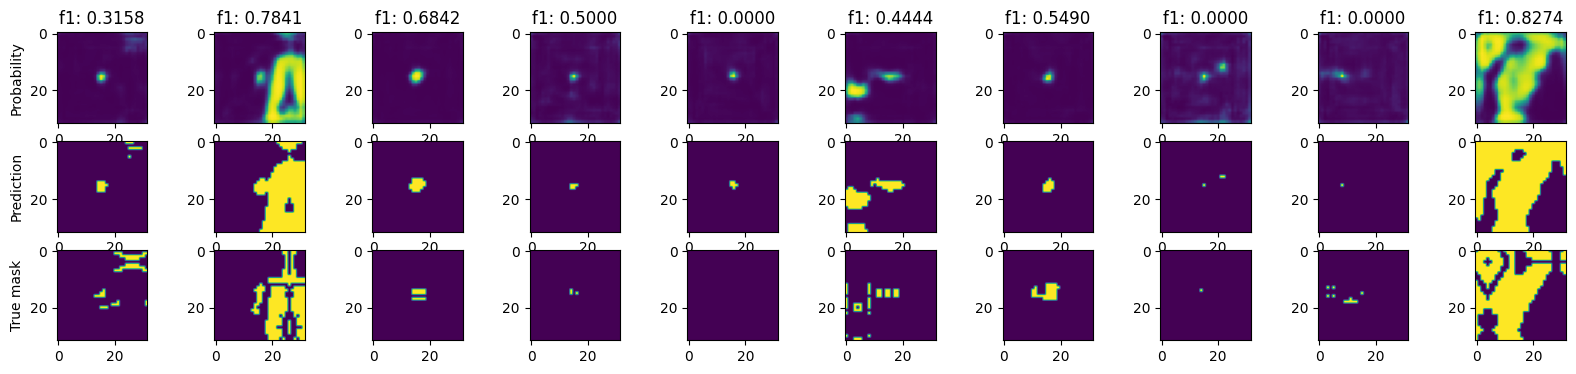

Epoch 5 training 25/25 [LR 0.000986] - loss: 0.4834: 100%|██████████| 25/25 [00:04<00:00,  5.21it/s]



Epoch 5 train loss = 0.4834, base f1 score (0.5 threshold) = 0.4243 (best threhold: 0.17 -> f1 0.4466)


100%|██████████| 7/7 [00:00<00:00, 21.34it/s]


Epoch 5 validation loss = 0.5290, base f1 score (0.5 threshold) = 0.3440 (best threhold: 0.07 -> f1 0.4604)
New best score: 0.4238 -> 0.4604


Epoch 6 training 25/25 [LR 0.000978] - loss: 0.4641: 100%|██████████| 25/25 [00:03<00:00,  7.16it/s]



Epoch 6 train loss = 0.4641, base f1 score (0.5 threshold) = 0.4234 (best threhold: 0.18 -> f1 0.4591)


100%|██████████| 7/7 [00:00<00:00, 21.19it/s]


Epoch 6 validation loss = 0.4576, base f1 score (0.5 threshold) = 0.4572 (best threhold: 0.36 -> f1 0.4767)
New best score: 0.4604 -> 0.4767


Epoch 7 training 25/25 [LR 0.000967] - loss: 0.4465: 100%|██████████| 25/25 [00:04<00:00,  5.89it/s]



Epoch 7 train loss = 0.4465, base f1 score (0.5 threshold) = 0.4341 (best threhold: 0.2 -> f1 0.4583)


100%|██████████| 7/7 [00:00<00:00, 13.09it/s]


Epoch 7 validation loss = 0.6590, base f1 score (0.5 threshold) = 0.4140 (best threhold: 0.8 -> f1 0.4441)


Epoch 8 training 25/25 [LR 0.000954] - loss: 0.4399: 100%|██████████| 25/25 [00:03<00:00,  6.47it/s]



Epoch 8 train loss = 0.4399, base f1 score (0.5 threshold) = 0.4417 (best threhold: 0.18 -> f1 0.4633)


100%|██████████| 7/7 [00:00<00:00,  8.32it/s]


Epoch 8 validation loss = 0.4617, base f1 score (0.5 threshold) = 0.4259 (best threhold: 0.12 -> f1 0.4742)


Epoch 9 training 25/25 [LR 0.000939] - loss: 0.4359: 100%|██████████| 25/25 [00:04<00:00,  5.98it/s]



Epoch 9 train loss = 0.4359, base f1 score (0.5 threshold) = 0.4431 (best threhold: 0.16 -> f1 0.4675)


100%|██████████| 7/7 [00:00<00:00, 13.03it/s]


Epoch 9 validation loss = 0.4487, base f1 score (0.5 threshold) = 0.3858 (best threhold: 0.06 -> f1 0.4764)


,0,1,2,3,4
pv_coverage_class,0.0,1.000000,2.000000,3.00000,4.000000
f1_scores,0.2,0.448169,0.791565,0.87001,0.915616


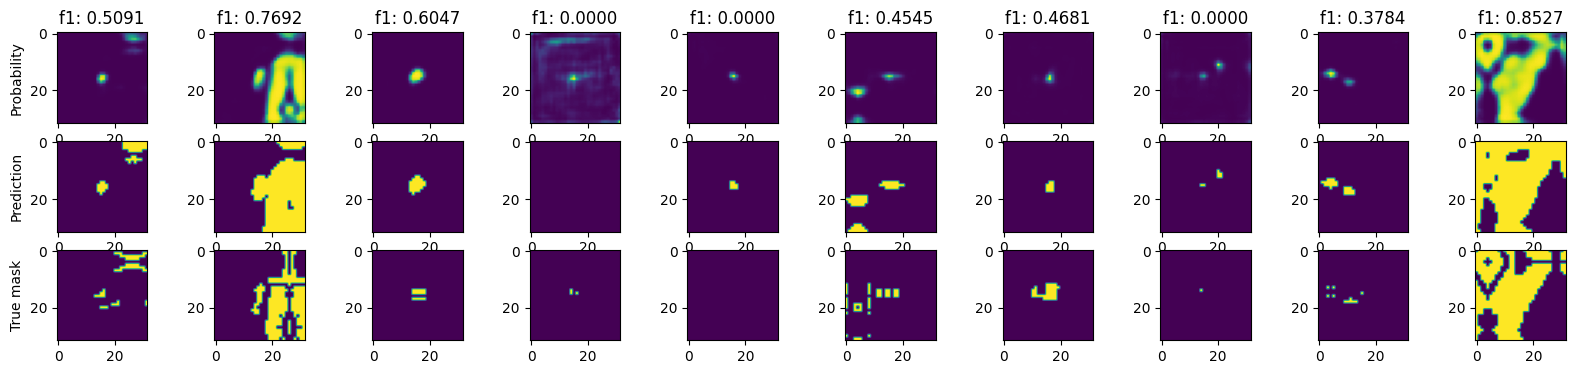

Epoch 10 training 25/25 [LR 0.000922] - loss: 0.4194: 100%|██████████| 25/25 [00:03<00:00,  7.13it/s]



Epoch 10 train loss = 0.4194, base f1 score (0.5 threshold) = 0.4658 (best threhold: 0.2 -> f1 0.4889)


100%|██████████| 7/7 [00:00<00:00, 20.82it/s]


Epoch 10 validation loss = 0.4226, base f1 score (0.5 threshold) = 0.4413 (best threhold: 0.24 -> f1 0.4777)
New best score: 0.4767 -> 0.4777


Epoch 11 training 25/25 [LR 0.000904] - loss: 0.4087: 100%|██████████| 25/25 [00:03<00:00,  6.81it/s]



Epoch 11 train loss = 0.4087, base f1 score (0.5 threshold) = 0.4664 (best threhold: 0.14 -> f1 0.4853)


100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


Epoch 11 validation loss = 0.4527, base f1 score (0.5 threshold) = 0.4185 (best threhold: 0.1 -> f1 0.5004)
New best score: 0.4777 -> 0.5004


Epoch 12 training 25/25 [LR 0.000883] - loss: 0.4021: 100%|██████████| 25/25 [00:04<00:00,  5.67it/s]



Epoch 12 train loss = 0.4021, base f1 score (0.5 threshold) = 0.4663 (best threhold: 0.16 -> f1 0.4883)


100%|██████████| 7/7 [00:00<00:00, 20.31it/s]


Epoch 12 validation loss = 0.4364, base f1 score (0.5 threshold) = 0.3985 (best threhold: 0.06 -> f1 0.4858)


Epoch 13 training 25/25 [LR 0.000861] - loss: 0.3952: 100%|██████████| 25/25 [00:03<00:00,  7.13it/s]



Epoch 13 train loss = 0.3952, base f1 score (0.5 threshold) = 0.4703 (best threhold: 0.19 -> f1 0.4933)


100%|██████████| 7/7 [00:00<00:00, 20.18it/s]


Epoch 13 validation loss = 0.5797, base f1 score (0.5 threshold) = 0.3050 (best threhold: 0.61 -> f1 0.3058)


Epoch 14 training 25/25 [LR 0.000838] - loss: 0.3874: 100%|██████████| 25/25 [00:04<00:00,  5.81it/s]



Epoch 14 train loss = 0.3874, base f1 score (0.5 threshold) = 0.4641 (best threhold: 0.13 -> f1 0.4993)


100%|██████████| 7/7 [00:00<00:00, 13.21it/s]


Epoch 14 validation loss = 0.3954, base f1 score (0.5 threshold) = 0.5134 (best threhold: 0.37 -> f1 0.5170)


,0,1,2,3,4
pv_coverage_class,0.000000,1.00000,2.00000,3.000000,4.000000
f1_scores,0.066667,0.50391,0.85108,0.887994,0.918663


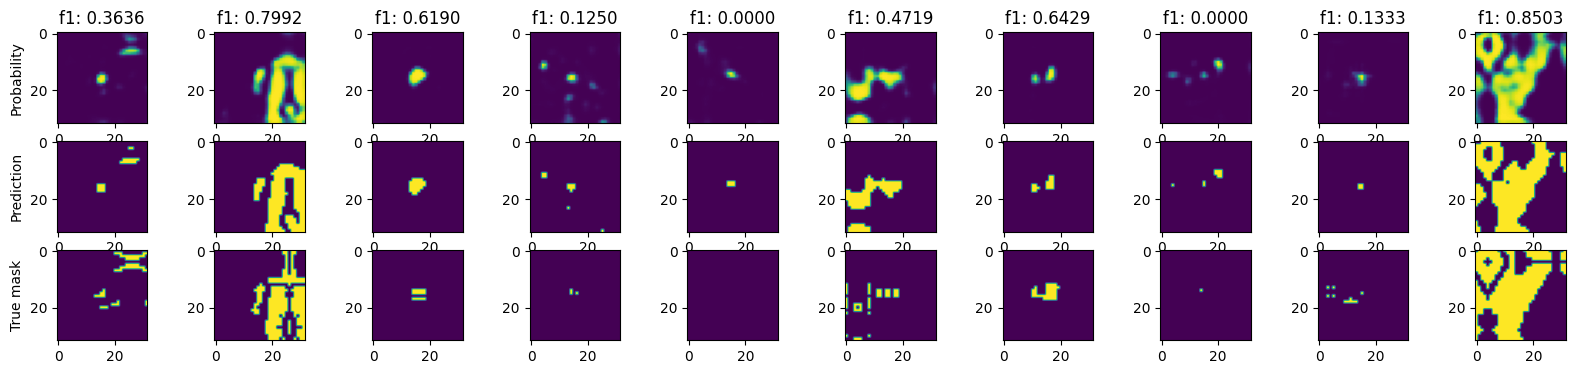

New best score: 0.5004 -> 0.5170


Epoch 15 training 25/25 [LR 0.000813] - loss: 0.3834: 100%|██████████| 25/25 [00:03<00:00,  7.05it/s]



Epoch 15 train loss = 0.3834, base f1 score (0.5 threshold) = 0.4758 (best threhold: 0.13 -> f1 0.5070)


100%|██████████| 7/7 [00:00<00:00, 15.78it/s]


Epoch 15 validation loss = 0.4898, base f1 score (0.5 threshold) = 0.3284 (best threhold: 0.04 -> f1 0.4651)


Epoch 16 training 25/25 [LR 0.000786] - loss: 0.3842: 100%|██████████| 25/25 [00:04<00:00,  5.42it/s]



Epoch 16 train loss = 0.3842, base f1 score (0.5 threshold) = 0.4769 (best threhold: 0.19 -> f1 0.5022)


100%|██████████| 7/7 [00:00<00:00,  8.90it/s]


Epoch 16 validation loss = 0.4457, base f1 score (0.5 threshold) = 0.4084 (best threhold: 0.07 -> f1 0.5036)


Epoch 17 training 25/25 [LR 0.000758] - loss: 0.3723: 100%|██████████| 25/25 [00:03<00:00,  7.02it/s]



Epoch 17 train loss = 0.3723, base f1 score (0.5 threshold) = 0.4917 (best threhold: 0.14 -> f1 0.5137)


100%|██████████| 7/7 [00:00<00:00, 20.88it/s]


Epoch 17 validation loss = 0.3915, base f1 score (0.5 threshold) = 0.4559 (best threhold: 0.12 -> f1 0.5103)


Epoch 18 training 25/25 [LR 0.000729] - loss: 0.3697: 100%|██████████| 25/25 [00:06<00:00,  3.68it/s]



Epoch 18 train loss = 0.3697, base f1 score (0.5 threshold) = 0.4828 (best threhold: 0.16 -> f1 0.5151)


100%|██████████| 7/7 [00:00<00:00,  9.78it/s]


Epoch 18 validation loss = 0.3977, base f1 score (0.5 threshold) = 0.4199 (best threhold: 0.07 -> f1 0.5143)


Epoch 19 training 25/25 [LR 0.000700] - loss: 0.3745: 100%|██████████| 25/25 [00:05<00:00,  4.87it/s]



Epoch 19 train loss = 0.3745, base f1 score (0.5 threshold) = 0.4803 (best threhold: 0.18 -> f1 0.5120)


100%|██████████| 7/7 [00:00<00:00, 19.38it/s]


Epoch 19 validation loss = 0.5117, base f1 score (0.5 threshold) = 0.4872 (best threhold: 0.82 -> f1 0.5046)


,0,1,2,3,4
pv_coverage_class,0.000000,1.000000,2.000000,3.000000,4.000000
f1_scores,0.233333,0.474421,0.841959,0.888345,0.917246


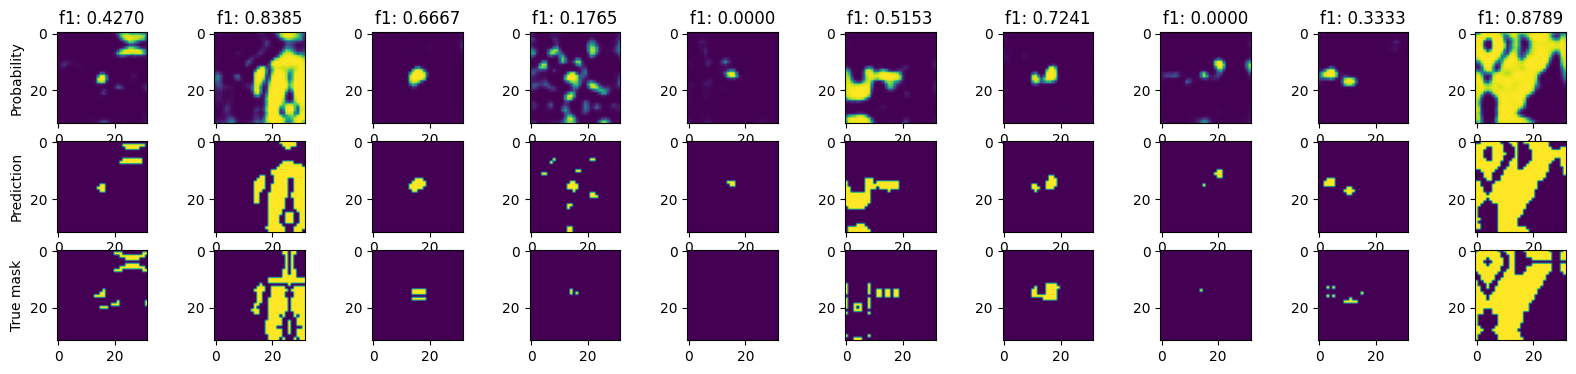

Epoch 20 training 25/25 [LR 0.000669] - loss: 0.3609: 100%|██████████| 25/25 [00:04<00:00,  5.23it/s]



Epoch 20 train loss = 0.3609, base f1 score (0.5 threshold) = 0.4960 (best threhold: 0.2 -> f1 0.5165)


100%|██████████| 7/7 [00:00<00:00, 20.09it/s]


Epoch 20 validation loss = 0.3675, base f1 score (0.5 threshold) = 0.4959 (best threhold: 0.15 -> f1 0.5298)
New best score: 0.5170 -> 0.5298


Epoch 21 training 25/25 [LR 0.000637] - loss: 0.3716: 100%|██████████| 25/25 [00:03<00:00,  6.86it/s]



Epoch 21 train loss = 0.3716, base f1 score (0.5 threshold) = 0.4937 (best threhold: 0.17 -> f1 0.5123)


100%|██████████| 7/7 [00:00<00:00, 19.67it/s]


Epoch 21 validation loss = 0.4257, base f1 score (0.5 threshold) = 0.5028 (best threhold: 0.56 -> f1 0.5066)


Epoch 22 training 25/25 [LR 0.000605] - loss: 0.3590: 100%|██████████| 25/25 [00:04<00:00,  6.16it/s]



Epoch 22 train loss = 0.3590, base f1 score (0.5 threshold) = 0.4964 (best threhold: 0.18 -> f1 0.5253)


100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


Epoch 22 validation loss = 0.3633, base f1 score (0.5 threshold) = 0.4846 (best threhold: 0.09 -> f1 0.5291)


Epoch 23 training 25/25 [LR 0.000573] - loss: 0.3547: 100%|██████████| 25/25 [00:04<00:00,  5.76it/s]



Epoch 23 train loss = 0.3547, base f1 score (0.5 threshold) = 0.4993 (best threhold: 0.16 -> f1 0.5255)


100%|██████████| 7/7 [00:00<00:00, 21.05it/s]


Epoch 23 validation loss = 0.4239, base f1 score (0.5 threshold) = 0.5210 (best threhold: 0.56 -> f1 0.5216)


Epoch 24 training 25/25 [LR 0.000540] - loss: 0.3561: 100%|██████████| 25/25 [00:03<00:00,  6.85it/s]



Epoch 24 train loss = 0.3561, base f1 score (0.5 threshold) = 0.5070 (best threhold: 0.15 -> f1 0.5274)


100%|██████████| 7/7 [00:00<00:00, 20.82it/s]


Epoch 24 validation loss = 0.3660, base f1 score (0.5 threshold) = 0.4645 (best threhold: 0.17 -> f1 0.5188)


,0,1,2,3,4
pv_coverage_class,0.000000,1.000000,2.000000,3.000000,4.000000
f1_scores,0.233333,0.491995,0.842296,0.890334,0.919519


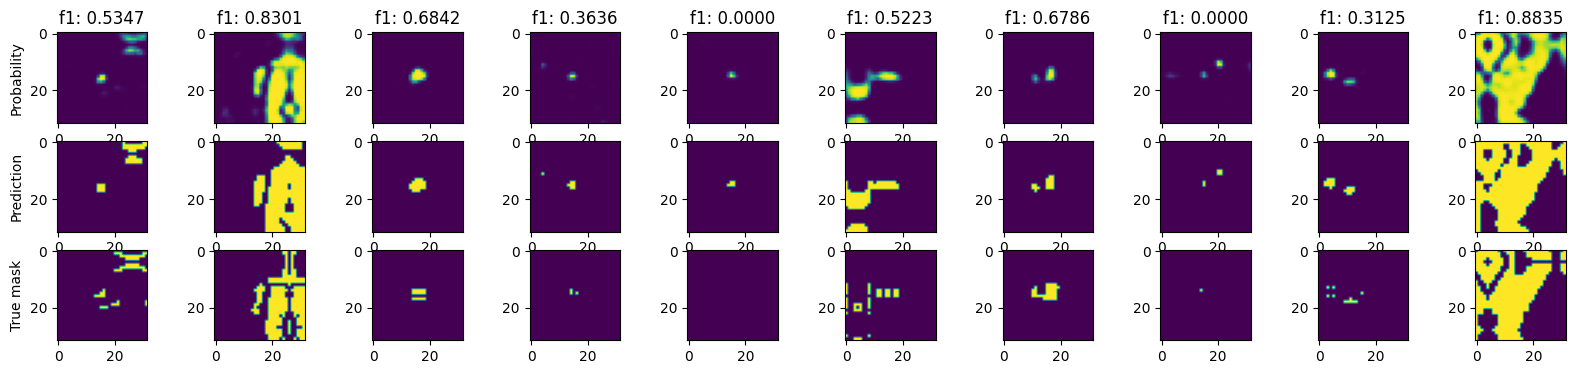

Epoch 25 training 25/25 [LR 0.000507] - loss: 0.3561: 100%|██████████| 25/25 [00:05<00:00,  4.38it/s]



Epoch 25 train loss = 0.3561, base f1 score (0.5 threshold) = 0.4997 (best threhold: 0.15 -> f1 0.5241)


100%|██████████| 7/7 [00:00<00:00, 13.13it/s]


Epoch 25 validation loss = 0.3977, base f1 score (0.5 threshold) = 0.5192 (best threhold: 0.48 -> f1 0.5204)


Epoch 26 training 25/25 [LR 0.000474] - loss: 0.3524: 100%|██████████| 25/25 [00:03<00:00,  6.90it/s]



Epoch 26 train loss = 0.3524, base f1 score (0.5 threshold) = 0.4971 (best threhold: 0.15 -> f1 0.5241)


100%|██████████| 7/7 [00:00<00:00, 20.57it/s]


Epoch 26 validation loss = 0.3629, base f1 score (0.5 threshold) = 0.4978 (best threhold: 0.11 -> f1 0.5268)


Epoch 27 training 25/25 [LR 0.000441] - loss: 0.3573: 100%|██████████| 25/25 [00:04<00:00,  6.13it/s]



Epoch 27 train loss = 0.3573, base f1 score (0.5 threshold) = 0.4934 (best threhold: 0.15 -> f1 0.5239)


100%|██████████| 7/7 [00:00<00:00, 12.62it/s]


Epoch 27 validation loss = 0.3641, base f1 score (0.5 threshold) = 0.4704 (best threhold: 0.17 -> f1 0.5295)


Epoch 28 training 25/25 [LR 0.000408] - loss: 0.3533: 100%|██████████| 25/25 [00:04<00:00,  5.61it/s]



Epoch 28 train loss = 0.3533, base f1 score (0.5 threshold) = 0.5088 (best threhold: 0.17 -> f1 0.5267)


100%|██████████| 7/7 [00:00<00:00, 19.52it/s]


Epoch 28 validation loss = 0.3554, base f1 score (0.5 threshold) = 0.5093 (best threhold: 0.24 -> f1 0.5253)


Epoch 29 training 25/25 [LR 0.000376] - loss: 0.3451: 100%|██████████| 25/25 [00:03<00:00,  7.00it/s]



Epoch 29 train loss = 0.3451, base f1 score (0.5 threshold) = 0.4902 (best threhold: 0.14 -> f1 0.5231)


100%|██████████| 7/7 [00:00<00:00, 20.75it/s]


Epoch 29 validation loss = 0.3746, base f1 score (0.5 threshold) = 0.5166 (best threhold: 0.3 -> f1 0.5251)


,0,1,2,3,4
pv_coverage_class,0.0,1.000000,2.00000,3.000000,4.000000
f1_scores,0.2,0.501478,0.85129,0.901252,0.920981


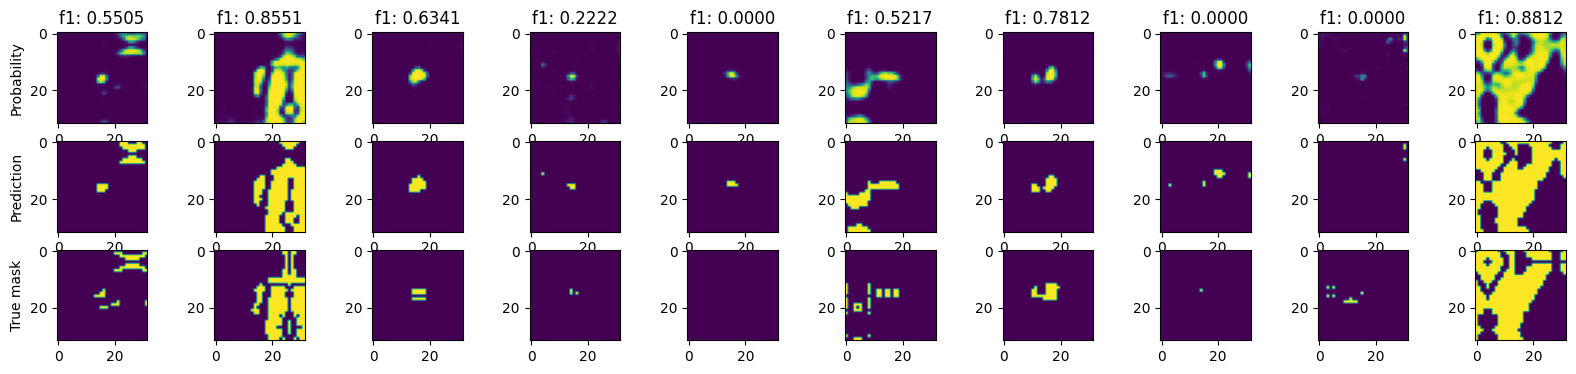

Epoch 30 training 25/25 [LR 0.000344] - loss: 0.3454: 100%|██████████| 25/25 [00:04<00:00,  5.36it/s]



Epoch 30 train loss = 0.3454, base f1 score (0.5 threshold) = 0.4982 (best threhold: 0.16 -> f1 0.5254)


100%|██████████| 7/7 [00:00<00:00, 20.12it/s]


Epoch 30 validation loss = 0.3636, base f1 score (0.5 threshold) = 0.4766 (best threhold: 0.1 -> f1 0.5297)


Epoch 31 training 25/25 [LR 0.000313] - loss: 0.3353: 100%|██████████| 25/25 [00:03<00:00,  6.36it/s]



Epoch 31 train loss = 0.3353, base f1 score (0.5 threshold) = 0.5040 (best threhold: 0.14 -> f1 0.5311)


100%|██████████| 7/7 [00:00<00:00, 20.01it/s]


Epoch 31 validation loss = 0.3585, base f1 score (0.5 threshold) = 0.4880 (best threhold: 0.08 -> f1 0.5192)


Epoch 32 training 25/25 [LR 0.000283] - loss: 0.3466: 100%|██████████| 25/25 [00:04<00:00,  5.57it/s]



Epoch 32 train loss = 0.3466, base f1 score (0.5 threshold) = 0.5035 (best threhold: 0.2 -> f1 0.5303)


100%|██████████| 7/7 [00:00<00:00, 13.40it/s]


Epoch 32 validation loss = 0.3605, base f1 score (0.5 threshold) = 0.5092 (best threhold: 0.21 -> f1 0.5377)
New best score: 0.5298 -> 0.5377


Epoch 33 training 25/25 [LR 0.000254] - loss: 0.3426: 100%|██████████| 25/25 [00:03<00:00,  6.26it/s]



Epoch 33 train loss = 0.3426, base f1 score (0.5 threshold) = 0.5026 (best threhold: 0.15 -> f1 0.5334)


100%|██████████| 7/7 [00:00<00:00, 20.35it/s]


Epoch 33 validation loss = 0.3478, base f1 score (0.5 threshold) = 0.5095 (best threhold: 0.23 -> f1 0.5343)


Epoch 34 training 25/25 [LR 0.000225] - loss: 0.3418: 100%|██████████| 25/25 [00:03<00:00,  6.86it/s]



Epoch 34 train loss = 0.3418, base f1 score (0.5 threshold) = 0.5101 (best threhold: 0.16 -> f1 0.5341)


100%|██████████| 7/7 [00:00<00:00, 20.12it/s]


Epoch 34 validation loss = 0.3465, base f1 score (0.5 threshold) = 0.5108 (best threhold: 0.1 -> f1 0.5414)


,0,1,2,3,4
pv_coverage_class,0.0,1.000000,2.000000,3.000000,4.000000
f1_scores,0.1,0.530942,0.852831,0.893943,0.920906


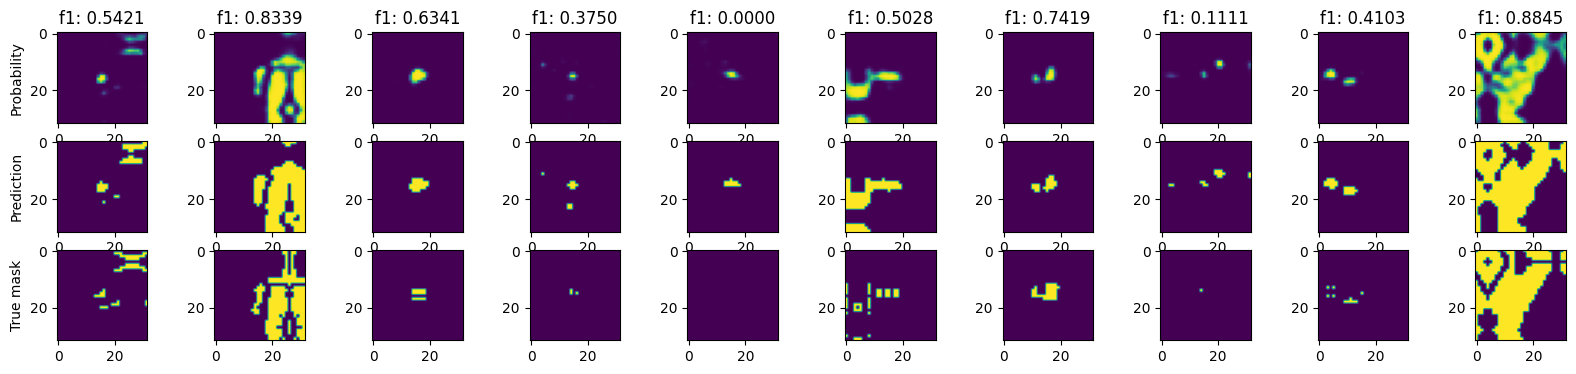

New best score: 0.5377 -> 0.5414


Epoch 35 training 25/25 [LR 0.000198] - loss: 0.3370: 100%|██████████| 25/25 [00:03<00:00,  6.56it/s]



Epoch 35 train loss = 0.3370, base f1 score (0.5 threshold) = 0.5031 (best threhold: 0.13 -> f1 0.5303)


100%|██████████| 7/7 [00:00<00:00, 18.41it/s]


Epoch 35 validation loss = 0.3431, base f1 score (0.5 threshold) = 0.4875 (best threhold: 0.12 -> f1 0.5437)
New best score: 0.5414 -> 0.5437


Epoch 36 training 25/25 [LR 0.000173] - loss: 0.3371: 100%|██████████| 25/25 [00:03<00:00,  6.44it/s]



Epoch 36 train loss = 0.3371, base f1 score (0.5 threshold) = 0.4967 (best threhold: 0.11 -> f1 0.5319)


100%|██████████| 7/7 [00:00<00:00, 12.64it/s]


Epoch 36 validation loss = 0.3564, base f1 score (0.5 threshold) = 0.5068 (best threhold: 0.22 -> f1 0.5381)


Epoch 37 training 25/25 [LR 0.000148] - loss: 0.3341: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s]



Epoch 37 train loss = 0.3341, base f1 score (0.5 threshold) = 0.4989 (best threhold: 0.16 -> f1 0.5399)


100%|██████████| 7/7 [00:00<00:00, 18.60it/s]


Epoch 37 validation loss = 0.3511, base f1 score (0.5 threshold) = 0.4769 (best threhold: 0.14 -> f1 0.5364)


Epoch 38 training 25/25 [LR 0.000126] - loss: 0.3410: 100%|██████████| 25/25 [00:03<00:00,  6.73it/s]



Epoch 38 train loss = 0.3410, base f1 score (0.5 threshold) = 0.5034 (best threhold: 0.18 -> f1 0.5346)


100%|██████████| 7/7 [00:00<00:00, 18.73it/s]


Epoch 38 validation loss = 0.3420, base f1 score (0.5 threshold) = 0.5052 (best threhold: 0.16 -> f1 0.5381)


Epoch 39 training 25/25 [LR 0.000105] - loss: 0.3296: 100%|██████████| 25/25 [00:03<00:00,  6.42it/s]



Epoch 39 train loss = 0.3296, base f1 score (0.5 threshold) = 0.5122 (best threhold: 0.14 -> f1 0.5416)


100%|██████████| 7/7 [00:00<00:00, 13.19it/s]


Epoch 39 validation loss = 0.3450, base f1 score (0.5 threshold) = 0.4933 (best threhold: 0.17 -> f1 0.5322)


,0,1,2,3,4
pv_coverage_class,0.0,1.000000,2.000000,3.000000,4.000000
f1_scores,0.2,0.509264,0.860993,0.903568,0.922305


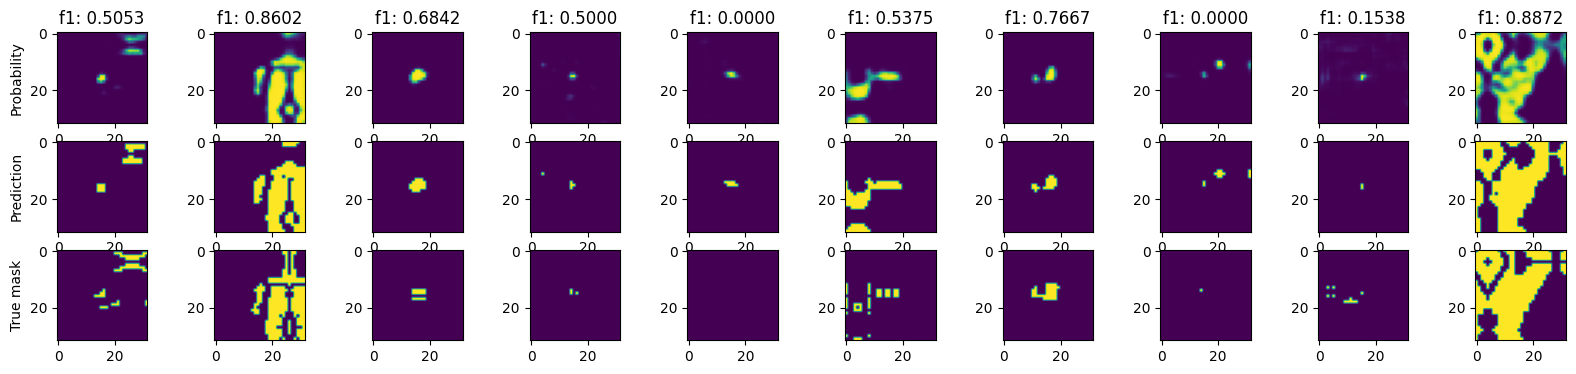

Epoch 40 training 25/25 [LR 0.000085] - loss: 0.3292: 100%|██████████| 25/25 [00:03<00:00,  6.58it/s]



Epoch 40 train loss = 0.3292, base f1 score (0.5 threshold) = 0.5162 (best threhold: 0.17 -> f1 0.5393)


100%|██████████| 7/7 [00:00<00:00, 18.95it/s]


Epoch 40 validation loss = 0.3455, base f1 score (0.5 threshold) = 0.4828 (best threhold: 0.12 -> f1 0.5305)


Epoch 41 training 25/25 [LR 0.000068] - loss: 0.3239: 100%|██████████| 25/25 [00:03<00:00,  6.43it/s]



Epoch 41 train loss = 0.3239, base f1 score (0.5 threshold) = 0.5038 (best threhold: 0.11 -> f1 0.5382)


100%|██████████| 7/7 [00:00<00:00, 12.57it/s]


Epoch 41 validation loss = 0.3427, base f1 score (0.5 threshold) = 0.5062 (best threhold: 0.17 -> f1 0.5468)
New best score: 0.5437 -> 0.5468


Epoch 42 training 25/25 [LR 0.000052] - loss: 0.3355: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s]



Epoch 42 train loss = 0.3355, base f1 score (0.5 threshold) = 0.5092 (best threhold: 0.21 -> f1 0.5336)


100%|██████████| 7/7 [00:00<00:00, 19.31it/s]


Epoch 42 validation loss = 0.3431, base f1 score (0.5 threshold) = 0.4981 (best threhold: 0.15 -> f1 0.5407)


Epoch 43 training 25/25 [LR 0.000038] - loss: 0.3229: 100%|██████████| 25/25 [00:03<00:00,  6.70it/s]



Epoch 43 train loss = 0.3229, base f1 score (0.5 threshold) = 0.5124 (best threhold: 0.14 -> f1 0.5415)


100%|██████████| 7/7 [00:00<00:00, 19.69it/s]


Epoch 43 validation loss = 0.3397, base f1 score (0.5 threshold) = 0.5236 (best threhold: 0.23 -> f1 0.5459)


Epoch 44 training 25/25 [LR 0.000027] - loss: 0.3208: 100%|██████████| 25/25 [00:04<00:00,  5.47it/s]



Epoch 44 train loss = 0.3208, base f1 score (0.5 threshold) = 0.5154 (best threhold: 0.18 -> f1 0.5375)


100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 44 validation loss = 0.3393, base f1 score (0.5 threshold) = 0.5118 (best threhold: 0.16 -> f1 0.5481)


,0,1,2,3,4
pv_coverage_class,0.0,1.0000,2.00000,3.000000,4.000000
f1_scores,0.2,0.5292,0.85998,0.901001,0.921337


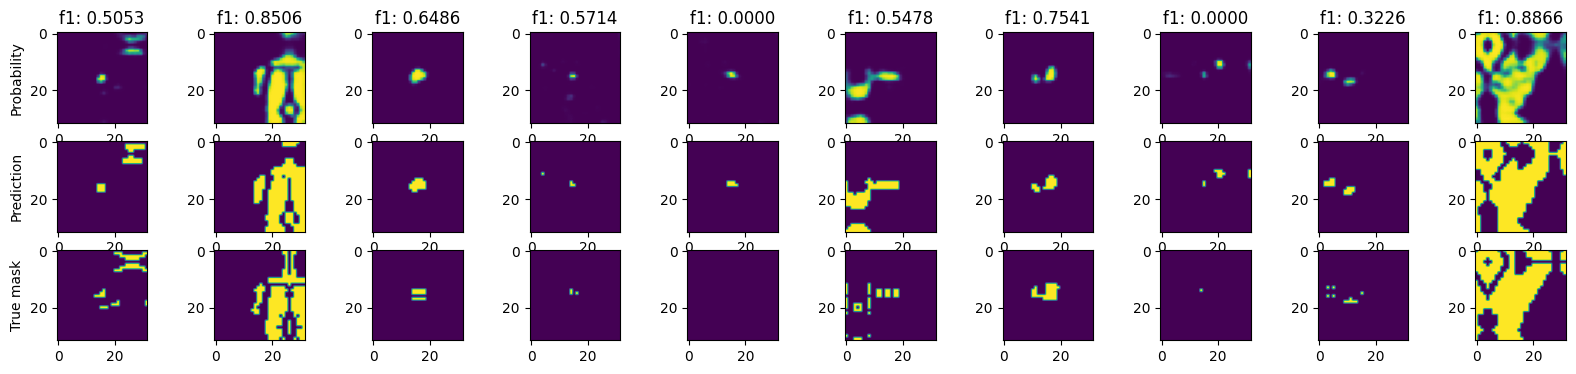

New best score: 0.5468 -> 0.5481


Epoch 45 training 25/25 [LR 0.000017] - loss: 0.3229: 100%|██████████| 25/25 [00:03<00:00,  6.45it/s]



Epoch 45 train loss = 0.3229, base f1 score (0.5 threshold) = 0.5123 (best threhold: 0.17 -> f1 0.5386)


100%|██████████| 7/7 [00:00<00:00, 16.96it/s]


Epoch 45 validation loss = 0.3380, base f1 score (0.5 threshold) = 0.5089 (best threhold: 0.21 -> f1 0.5476)


Epoch 46 training 25/25 [LR 0.000010] - loss: 0.3249: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s]



Epoch 46 train loss = 0.3249, base f1 score (0.5 threshold) = 0.5094 (best threhold: 0.16 -> f1 0.5389)


100%|██████████| 7/7 [00:00<00:00, 11.34it/s]


Epoch 46 validation loss = 0.3378, base f1 score (0.5 threshold) = 0.5051 (best threhold: 0.21 -> f1 0.5506)
New best score: 0.5481 -> 0.5506


Epoch 47 training 25/25 [LR 0.000004] - loss: 0.3300: 100%|██████████| 25/25 [00:05<00:00,  4.49it/s]



Epoch 47 train loss = 0.3300, base f1 score (0.5 threshold) = 0.5101 (best threhold: 0.18 -> f1 0.5398)


100%|██████████| 7/7 [00:00<00:00, 19.63it/s]


Epoch 47 validation loss = 0.3382, base f1 score (0.5 threshold) = 0.5188 (best threhold: 0.2 -> f1 0.5503)


Epoch 48 training 25/25 [LR 0.000001] - loss: 0.3251: 100%|██████████| 25/25 [00:03<00:00,  6.55it/s]



Epoch 48 train loss = 0.3251, base f1 score (0.5 threshold) = 0.5086 (best threhold: 0.14 -> f1 0.5419)


100%|██████████| 7/7 [00:00<00:00, 18.79it/s]


Epoch 48 validation loss = 0.3384, base f1 score (0.5 threshold) = 0.5088 (best threhold: 0.17 -> f1 0.5512)
New best score: 0.5506 -> 0.5512


Epoch 49 training 25/25 [LR 0.000000] - loss: 0.3221: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s]



Epoch 49 train loss = 0.3221, base f1 score (0.5 threshold) = 0.5052 (best threhold: 0.15 -> f1 0.5389)


100%|██████████| 7/7 [00:00<00:00, 18.59it/s]


Epoch 49 validation loss = 0.3382, base f1 score (0.5 threshold) = 0.5102 (best threhold: 0.18 -> f1 0.5498)


,0,1,2,3,4
pv_coverage_class,0.000000,1.00000,2.000000,3.000000,4.00000
f1_scores,0.233333,0.52814,0.861437,0.901205,0.92155


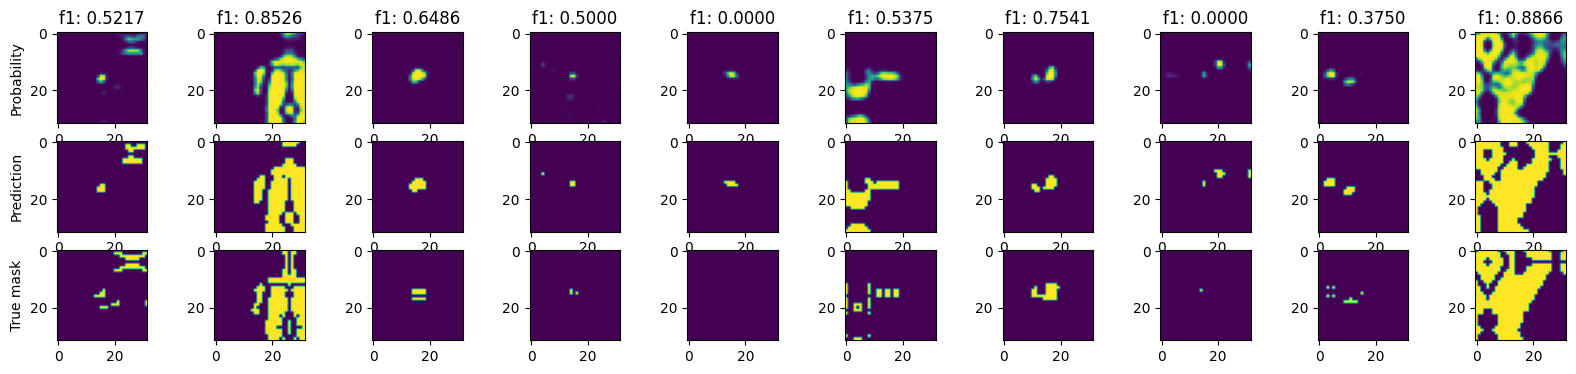

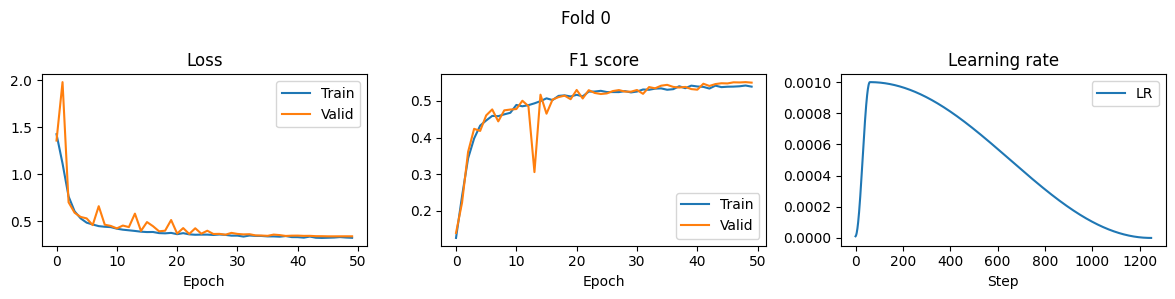

In [25]:
for FOLD in CFG.train_folds:

    seed_everything(CFG.seed)

    # PREPARE DATA
    fold_train_data = train_data[train_data["fold"] != FOLD].reset_index(drop=True)
    fold_valid_data = train_data[train_data["fold"] == FOLD].reset_index(drop=True)

    display(
        pd.merge(
            fold_valid_data.groupby(by=["pv_coverage_class"])["image_file_name"].count().rename("valid").reset_index(),
            fold_train_data.groupby(by=["pv_coverage_class"])["image_file_name"].count().rename("train").reset_index(),
             on="pv_coverage_class", how="left").T,)


    train_image_data, train_mask_data = load_image_masks(TRAIN_DATA_FOLDER, fold_train_data.image_file_name)
    valid_image_data, valid_mask_data = load_image_masks(TRAIN_DATA_FOLDER, fold_valid_data.image_file_name)

    train_dataset = ImageTrainDataset(train_image_data, train_mask_data, transforms=train_transforms)
    valid_dataset = ImageTrainDataset(valid_image_data, valid_mask_data, transforms=val_transforms)

    train_loader = DataLoader(
            train_dataset,
            batch_size=CFG.batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=False,
            drop_last=True
        )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        drop_last=False,
    )

    # PREPARE MODEL, OPTIMIZER AND SCHEDULER

    model = smp.MAnet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=12, classes=1)
    model = model.to(CFG.device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):_}")

    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,max_lr=CFG.lr, total_steps=CFG.epochs * len(train_loader),
        div_factor=1e2, final_div_factor=1e3, pct_start=0.05
        )


    # TRAIN FOLD
    learning_rate_history = []
    train_loss_history = []
    train_score_history = []
    val_loss_history = []
    val_score_history = []

    best_score = 0
    for epoch in range(0, CFG.epochs):
        train_loss, train_score, train_lr = train_epoch(CFG, model, train_loader, optimizer, scheduler, epoch)
        train_loss_history.append(train_loss)
        train_score_history.append(train_score)
        learning_rate_history.extend(train_lr)

        val_loss, val_score = evaluate_model(CFG, model, valid_loader, epoch)
        val_loss_history.append(val_loss)
        val_score_history.append(val_score)

        if (val_score > best_score):
            print(f"New best score: {best_score:.4f} -> {val_score:.4f}")
            best_score = val_score
            torch.save(model.state_dict(), f'/home/best_model_fold_{FOLD}.pth')

    # plot train and validation loss, score and LR
    fig, axes = plt.subplots(1,3, figsize=(12,3))
    axes[0].plot(train_loss_history, label="Train")
    axes[0].plot(val_loss_history, label="Valid")
    axes[0].title.set_text("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    axes[1].plot(train_score_history, label="Train")
    axes[1].plot(val_score_history, label="Valid")
    axes[1].title.set_text("F1 score")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()

    axes[2].plot(learning_rate_history, label="LR")
    axes[2].legend()
    axes[2].title.set_text("Learning rate")
    axes[2].set_xlabel("Step")
    fig.suptitle(f"Fold {FOLD}")
    fig.tight_layout()
    plt.show()

# Submission

In [26]:
os.makedirs('/home/output', exist_ok=True)
os.makedirs('/home/submission', exist_ok=True)

In [27]:
test_image_files = os.listdir(f'{TEST_DATA_FOLDER}')
test_image_data = []

for fn in tqdm(test_image_files):
    postfix = fn.split("_")[3]
    test_image_data.append(tifffile.imread(f"{TEST_DATA_FOLDER}{fn}"))

100%|██████████| 2066/2066 [00:00<00:00, 2130.21it/s]


## Dataset

In [28]:
from torch.utils.data import DataLoader, Dataset

# pad image with reflect
test_image_transforms = v2.Compose([
    v2.ToImage(),
    v2.Pad((6,6), padding_mode="reflect"),
])

# pad masks with constant so we can easily detect which part was padded
test_mask_transforms = v2.Compose([
    v2.ToImage(),
    v2.Pad((6,6), padding_mode="constant", fill=0),
])

test_transforms = v2.Compose([
    v2.CenterCrop((32,32)),
    v2.ToDtype(torch.float32, scale=False),  # Normalize expects float input
])

class ImageTestDataset(Dataset):
    def __init__(
        self,
        file_names,
        images,
        transforms=None,
    ):
        self.file_names = file_names
        self.images = images

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        image = self.images[index] # scale by scaling factor
        mask = np.ones_like(image)

        image = test_image_transforms(image)
        mask = test_mask_transforms(mask)

        image, mask = test_transforms(image, mask)

        return {"image": image,
                "mask": mask[0, :],
                "shape": image.shape,
                "file_name": self.file_names[index],
                }

ds = ImageTestDataset(test_image_files, test_image_data)
d = ds.__getitem__(0)
print(d["image"].shape, d["mask"].shape, d["shape"], d["file_name"])

torch.Size([12, 32, 32]) torch.Size([32, 32]) torch.Size([12, 32, 32]) evaluation_s2_image_540.tif


## Inference

In [29]:
def inference(cfg, model, data_loader):
    model.eval()
    mask_predictions = []
    padding_masks = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    for step, data in tk0:
        input = data["image"].to(cfg.device, non_blocking=True)

        with torch.no_grad():
            logits = model(input)

        padding_masks.append(data["mask"])
        mask_predictions.append(logits.detach().cpu())

    padding_masks = torch.cat(padding_masks, dim=0)
    mask_predictions = F.sigmoid(torch.cat(mask_predictions, dim=0))
    return mask_predictions, padding_masks

In [30]:
test_dataset = ImageTestDataset(test_image_files, test_image_data)
test_loader = DataLoader(
    test_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=False,
)

In [31]:
seed_everything(CFG.seed)

test_mask_predictions = []
test_padding_masks = []

for FOLD in CFG.train_folds:
    print("Inference for fold:", FOLD)
    model = smp.MAnet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=12, classes=1)
    model = model.to(CFG.device)

    valid_image_data, valid_mask_data = load_image_masks(TRAIN_DATA_FOLDER, train_data[train_data["fold"] == FOLD].image_file_name)
    valid_dataset = ImageTrainDataset(valid_image_data, valid_mask_data, transforms=val_transforms)

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        drop_last=False,
    )

    model.load_state_dict(torch.load(f"/home/best_model_fold_{FOLD}.pth", map_location=CFG.device))
    val_loss, val_score = evaluate_model(CFG, model, valid_loader, epoch=0)
    predictions, padding_masks = inference(CFG, model, test_loader)

    test_mask_predictions.append(predictions)
    test_padding_masks.append(padding_masks)

# Average predictions over folds
if (len(CFG.train_folds) > 1):
    test_mask_predictions = torch.stack(test_mask_predictions, axis=-1).mean(axis=-1)
    test_padding_masks = torch.stack(test_padding_masks, axis=-1).mean(axis=-1)
else:
    test_mask_predictions = test_mask_predictions[0]
    test_padding_masks = test_padding_masks[0]

Inference for fold: 0


100%|██████████| 7/7 [00:00<00:00, 19.65it/s]


Epoch 0 validation loss = 0.3384, base f1 score (0.5 threshold) = 0.5088 (best threhold: 0.17 -> f1 0.5512)


100%|██████████| 33/33 [00:01<00:00, 19.05it/s]


In [33]:
print(test_mask_predictions.shape)
assert test_mask_predictions.shape[0] == 2066
assert test_mask_predictions.shape[1] == 1
assert test_mask_predictions.shape[2] == 32
assert test_mask_predictions.shape[3] == 32

torch.Size([2066, 1, 32, 32])


In [34]:
THRESHOLD = 0.17

target_sizes = [np.shape(im) for im in test_image_data]

for file_name, target_size, mask_prediction, padding_mask in zip(test_image_files, target_sizes, test_mask_predictions, test_padding_masks):
    mask_prediction = mask_prediction > THRESHOLD
    # remove padding and reshape prediction to correct size
    padding_mask = padding_mask > 0
    mask_prediction = torch.masked_select(mask_prediction, padding_mask).reshape(target_size[:2]).numpy().astype(np.uint8)

    tifffile.imwrite("/home/submission/" + file_name.replace("s2_image", "mask"), mask_prediction)

In [35]:
!rm /home/output/submission.zip
!cd /home/submission && zip -qq -r /home/output/submission.zip  *.tif

rm: cannot remove '/home/output/submission.zip': No such file or directory


In [36]:
from google.colab import files
files.download('/home/output/submission.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>